## [kernel](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)
* ### Mean encoding
    - Average sale per (month)
    - Average sale per (month, item)
    - Average sale per (month, item_cat1)
    - Average sale per (month, item_cat2)
    - Average sale per (month, shop)
    - Average sale per (month, city)
    - Average sale per (month, type)
    - Average sale per (month, shop, item_cat1)
    - Average sale per (month, shop, item_cat2)
    - Average sale per (month, shop, type), here shop should be redundant
    - Average sale per (month, item, city)
    
    
    
**There are many combinations of features. How to know what combinations are good?**

* ### Trend (relative difference/growth ratio)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import sys
import time
import gc
import itertools
import tqdm
import time
import copy

from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss

if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass
    
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from numba import jit

%matplotlib inline

## Feature Engineering

### Load data

In [2]:
# Load data
train = pd.read_csv('all/sales_train.csv.gz')
test = pd.read_csv('all/test.csv.gz')
shop = pd.read_csv('all/shops-translated.csv')
item = pd.read_csv('all/item_category.csv')

test.set_index('ID', inplace=True)
item.drop(['item_name_translated'], axis=1, inplace=True)
shop.drop(['Name'], axis=1, inplace=True)

le = LabelEncoder()
item['item_cat1'] = le.fit_transform(item['item_cat1'].astype(str))
item['item_cat2'] = le.fit_transform(item['item_cat2'].astype(str))
shop['City'] = le.fit_transform(shop['City'])
shop['Type'] = le.fit_transform(shop['Type'])

# test = test.merge(item, on='item_id', how='left')
# test = test.merge(shop, on='shop_id', how='left')

### Relative count difference for each (shop, item) pair

In [3]:
cnt = train.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', 
                        values='item_cnt_day', 
                        aggfunc='sum').fillna(0.0)
cnt.columns = ['cnt_'+str(k) for k in cnt.columns]

In [6]:
cnt_diff = cnt.diff(axis=1)/cnt.replace(0, 1).shift(axis=1, periods=1)
cnt_diff.fillna(0.0, inplace=True)

In [7]:
cnt_diff.head()

cnt_0      cnt_1  cnt_2  cnt_3  cnt_4  cnt_5  cnt_6  cnt_7  \
shop_id item_id                                                               
0       30         0.0  31.000000   -1.0    0.0    0.0    0.0    0.0    0.0   
        31         0.0  11.000000   -1.0    0.0    0.0    0.0    0.0    0.0   
        32         0.0   0.666667   -1.0    0.0    0.0    0.0    0.0    0.0   
        33         0.0   0.000000   -1.0    0.0    0.0    0.0    0.0    0.0   
        35         0.0  13.000000   -1.0    0.0    0.0    0.0    0.0    0.0   

                 cnt_8  cnt_9   ...    cnt_24  cnt_25  cnt_26  cnt_27  cnt_28  \
shop_id item_id                 ...                                             
0       30         0.0    0.0   ...       0.0     0.0     0.0     0.0     0.0   
        31         0.0    0.0   ...       0.0     0.0     0.0     0.0     0.0   
        32         0.0    0.0   ...       0.0     0.0     0.0     0.0     0.0   
        33         0.0    0.0   ...       0.0     0.0     0.0     0.0     0.0   
        35         0.0    0.0   ...       0.0     0.0     0.0     0.0     0.0   

                 cnt_29  cnt_30  cnt_31  cnt_32  cnt_33  
shop_id item_id                                          
0       30          0.0     0.0     0.0     0.0     0.0  
        31          0.0     0.0     0.0     0.0     0.0  
        32          0.0     0.0     0.0     0.0     0.0  
        33          0.0     0.0     0.0     0.0     0.0  
        35          0.0     0.0     0.0     0.0     0.0  

[5 rows x 34 columns]

In [8]:
cnt_diff_2 = cnt.diff(axis=1, periods=2)/cnt.replace(0, 1).shift(axis=1, periods=2)
cnt_diff_2.fillna(0.0, inplace=True)

In [10]:
cnt_diff_2.shape

(424124, 34)

In [16]:
feature_dict = {}
for n in range(1, 13):
    key_name = 'cnt_diff_{}'.format(n)
    tmp = cnt.diff(axis=1, periods=n)/cnt.replace(0, 1).shift(axis=1, 
        periods=n)
    tmp.fillna(0.0, inplace=True)
    feature_dict[key_name] = tmp

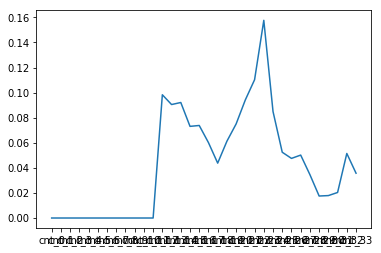

In [20]:
plt.plot(feature_dict['cnt_diff_12'].mean(axis=0))

### Relative count difference
* item_id, item_cat1, item_cat2
* shop_id, City, Type

| features | shop_id     | City | Type|
|---       | ---         | ---  | --- |
| **item_id**  |  x   |  x    |  x   |
| **item_cat1**|   x      | x     |  x   |
| **item_cat2**|    x    |   x   |   x  |

In [26]:
train = train.merge(item, on=['item_id'], how='left')
train = train.merge(shop, on=['shop_id'], how='left')

In [27]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cat1,item_cat2,City,Type
0,02.01.2013,0,59,22154,999.00,1.0,3,9,27,1
1,03.01.2013,0,25,2552,899.00,1.0,12,56,8,5
2,05.01.2013,0,25,2552,899.00,-1.0,12,56,8,5
3,06.01.2013,0,25,2554,1709.05,1.0,12,56,8,5
4,15.01.2013,0,25,2555,1099.00,1.0,12,15,8,5


### What lag values are good?

Analyze lag values of feature importance from eda_11_2

In [62]:
u = pd.read_csv('eda_11_2_feature_importance_names.csv', header=None)

a = u.iloc[:200, 0]

b = []
for k in a:
    try:
        b.append(int(k.split('_')[-1]))
    except:
        pass

b = pd.Series(b)

c = b.value_counts()
c.index = 33-c.index
c

1     22
10    11
4     11
2     10
25     9
31     9
5      8
3      8
6      8
18     8
8      7
7      7
9      7
28     6
27     6
13     5
14     5
30     5
12     5
29     5
11     5
22     5
23     5
20     4
16     3
17     3
15     3
26     2
24     2
19     2
21     1
dtype: int64

In [65]:
d = pd.DataFrame(c)
d.reset_index(inplace=True)
d['index'] = d['index']%12

d.groupby(['index']).sum().sort_values(by=0, ascending=False)

,0
index,
1,36
6,21
4,20
7,18
2,17
3,17
5,16
10,16
8,11


In [85]:
a

,0,1
0,item_id-item_cnt_day-median_25,10046.156990
1,item_id-item_cnt_day-median_24,8492.271480
2,item_id-item_cnt_day-qh2_30,1957.000576
3,cnt_32,1239.551611
4,item_cat1-item_price-sum_5,1133.542834
5,item_cat1-item_cnt_day-mean_32,1076.209590
6,item_cat1-item_cnt_day-sum_26,942.857727
7,item_cat1-item_price-sum_6,752.754103
8,cnt_23,738.361800
9,City-sales-ql2_25,634.953674


In [124]:
a = u.iloc[:30, 0]

index_list = ['item_id', 'shop_id', 'City', 'Type', 'item_cat1', 'item_cat2']
column_list = ['date_block_num']
value_list = ['item_price', 'item_cnt_day', 'sales'] # ['item_price', 'item_cnt_day', 'sales']

quantile_low = lambda x: np.quantile(x, 0.25)
quantile_high = lambda x: np.quantile(x, 0.75)
quantile_low_2 = lambda x: np.quantile(x, 0.1)
quantile_high_2 = lambda x: np.quantile(x, 0.9)
aggfunc_list = ['sum', 'mean', 'std', 'median', 'ql', 'qh', 'ql2', 'qh2']

hist_index = {k: 0 for k in index_list}
for k in a.values:
    for i in index_list:
        if i in k:
            hist_index[i] += 1
            
hist_value = {k: 0 for k in value_list}
for k in a.values:
    for i in value_list:
        if i in k:
            hist_value[i] += 1
            
hist_agg = {k: 0 for k in aggfunc_list}
for k in a.values:
    for i in aggfunc_list:
        if i in k:
            hist_agg[i] += 1

In [125]:
hist_agg = pd.Series(hist_agg).sort_values(ascending=False)
hist_agg

sum       8
qh        7
qh2       4
mean      4
median    3
std       3
ql2       2
ql        2
dtype: int64

In [126]:
hist_value = pd.Series(hist_value).sort_values(ascending=False)
hist_value

item_cnt_day    13
item_price       9
sales            5
dtype: int64

In [127]:
hist_index = pd.Series(hist_index).sort_values(ascending=False)
hist_index

item_cat2    7
item_cat1    7
shop_id      5
City         4
item_id      4
Type         0
dtype: int64

In [128]:
features = list(set(['_'.join(k.split('_')[:-1]) for k in a.values]))

In [129]:
len(features)

24

In [130]:
features

['City-sales-ql2',
 'shop_id-item_cnt_day-std',
 'item_id-item_cnt_day-qh',
 'item_cat2-item_cnt_day-sum',
 'shop_id-item_cnt_day-sum',
 'item_cat1-item_price-sum',
 'item_cat2-item_price-qh',
 'City-item_price-qh',
 'shop_id-sales-std',
 'item_id-item_cnt_day-qh2',
 'shop_id-sales-mean',
 'item_cat1-item_price-ql2',
 'item_cat1-item_cnt_day-sum',
 'cnt',
 'item_cat1-item_cnt_day-mean',
 'item_cat1-item_price-median',
 'item_id-item_cnt_day-median',
 'City-item_price-qh2',
 'item_cat2-item_cnt_day-mean',
 'item_cat2-sales-mean',
 'item_cat2-item_price-qh2',
 'item_cat2-sales-qh2',
 'item_cat2-item_cnt_day-std',
 'City-item_cnt_day-sum']

#### Important lag values

- lag = 1, 6, 7, 10, 5 have high importance
- lag = 31 is not practical, since it is too long, and will generate too few samples
- lag = 14, 18, 13 can also be considered
- In general, lag <= 7, **12** or 18 is safe
- 同比1，2，3，4，5，6，7月份更重要

In [137]:
def find_related(features, name):
    tmp = []
    for f in features:
        if name in f:
            tmp.append(f)
#             print(f)
#     print('')
    tmp.sort()
    for f in tmp:
        print(f)
    print('')
    
    return tmp

In [138]:
city = find_related(features, 'City')
item_id = find_related(features, 'item_id')
item_cat1 = find_related(features, 'item_cat1')
item_cat2 = find_related(features, 'item_cat2')
shop_id = find_related(features, 'shop_id')

City-item_cnt_day-sum
City-item_price-qh
City-item_price-qh2
City-sales-ql2

item_id-item_cnt_day-median
item_id-item_cnt_day-qh
item_id-item_cnt_day-qh2

item_cat1-item_cnt_day-mean
item_cat1-item_cnt_day-sum
item_cat1-item_price-median
item_cat1-item_price-ql2
item_cat1-item_price-sum

item_cat2-item_cnt_day-mean
item_cat2-item_cnt_day-std
item_cat2-item_cnt_day-sum
item_cat2-item_price-qh
item_cat2-item_price-qh2
item_cat2-sales-mean
item_cat2-sales-qh2

shop_id-item_cnt_day-std
shop_id-item_cnt_day-sum
shop_id-sales-mean
shop_id-sales-std



In [139]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cat1,item_cat2,City,Type
0,02.01.2013,0,59,22154,999.00,1.0,3,9,27,1
1,03.01.2013,0,25,2552,899.00,1.0,12,56,8,5
2,05.01.2013,0,25,2552,899.00,-1.0,12,56,8,5
3,06.01.2013,0,25,2554,1709.05,1.0,12,56,8,5
4,15.01.2013,0,25,2555,1099.00,1.0,12,15,8,5
